In [1]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
#%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [2]:
import os
print(os.environ["LD_LIBRARY_PATH"])

$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, models, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, TimeDistributed, LSTM, SpatialDropout2D, concatenate
from tensorflow.keras.optimizers import SGD, Adam

2022-11-07 22:21:00.246546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 22:21:00.776651: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 22:21:01.892297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/:/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-11-07 22:21:01.892398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 

In [2]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-11-07 22:21:03.556737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 22:21:03.570427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 22:21:03.586859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 22:21:03.587046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-11-07 22:21:04.541651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 22:21:04.541892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 22:21:04.542095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Read the csv dataset to get the values for stage and discharge of the images

In [4]:
df = pd.read_csv("../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

Unnamed: 0           SensorTime          CaptureTime  \
0           0  2012-06-09 13:15:00  2012-06-09T13:09:07   
1           1  2012-06-09 13:15:00  2012-06-09T13:10:29   
2           2  2012-06-09 13:45:00  2012-06-09T13:44:01   
3           3  2012-06-09 14:45:00  2012-06-09T14:44:30   
4           4  2012-06-09 15:45:00  2012-06-09T15:44:59   

                                 Filename Agency  SiteNumber TimeZone  Stage  \
0  StateLineWeir_20120609_Farrell_001.jpg   USGS     6674500      MDT   2.99   
1  StateLineWeir_20120609_Farrell_002.jpg   USGS     6674500      MDT   2.99   
2  StateLineWeir_20120609_Farrell_003.jpg   USGS     6674500      MDT   2.96   
3  StateLineWeir_20120609_Farrell_004.jpg   USGS     6674500      MDT   2.94   
4  StateLineWeir_20120609_Farrell_005.jpg   USGS     6674500      MDT   2.94   

   Discharge        CalcTimestamp  ...  WeirPt2X  WeirPt2Y  WwRawLineMin  \
0      916.0  2020-03-11T16:58:28  ...        -1        -1           0.0   
1      916.0  2020-03-11T16:58:33  ...        -1        -1           0.0   
2      873.0  2020-03-11T16:58:40  ...        -1        -1           0.0   
3      846.0  2020-03-11T16:58:47  ...        -1        -1           0.0   
4      846.0  2020-03-11T16:58:55  ...        -1        -1           0.0   

   WwRawLineMax  WwRawLineMean  WwRawLineSigma  WwCurveLineMin  \
0           0.0            0.0             0.0             0.0   
1           0.0            0.0             0.0             0.0   
2           0.0            0.0             0.0             0.0   
3           0.0            0.0             0.0             0.0   
4           0.0            0.0             0.0             0.0   

   WwCurveLineMax  WwCurveLineMean  WwCurveLineSigma  
0             0.0              0.0               0.0  
1             0.0              0.0               0.0  
2             0.0              0.0               0.0  
3             0.0              0.0               0.0  
4             0.0              0.0               0.0  

[5 rows x 60 columns]

In [5]:
df = df[["Filename", "Stage", "Discharge", 'SensorTime']]

In [6]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df.head()

Filename  Stage  Discharge  \
0  StateLineWeir_20120609_Farrell_001.jpg   2.99      916.0   
1  StateLineWeir_20120609_Farrell_002.jpg   2.99      916.0   
2  StateLineWeir_20120609_Farrell_003.jpg   2.96      873.0   
3  StateLineWeir_20120609_Farrell_004.jpg   2.94      846.0   
4  StateLineWeir_20120609_Farrell_005.jpg   2.94      846.0   

           SensorTime  Year  
0 2012-06-09 13:15:00  2012  
1 2012-06-09 13:15:00  2012  
2 2012-06-09 13:45:00  2012  
3 2012-06-09 14:45:00  2012  
4 2012-06-09 15:45:00  2012

In [7]:
df = df.sort_values(by="SensorTime", ascending=True)
df.head()

Filename  Stage  Discharge  \
0  StateLineWeir_20120609_Farrell_001.jpg   2.99      916.0   
1  StateLineWeir_20120609_Farrell_002.jpg   2.99      916.0   
2  StateLineWeir_20120609_Farrell_003.jpg   2.96      873.0   
3  StateLineWeir_20120609_Farrell_004.jpg   2.94      846.0   
4  StateLineWeir_20120609_Farrell_005.jpg   2.94      846.0   

           SensorTime  Year  
0 2012-06-09 13:15:00  2012  
1 2012-06-09 13:15:00  2012  
2 2012-06-09 13:45:00  2012  
3 2012-06-09 14:45:00  2012  
4 2012-06-09 15:45:00  2012

### Remove outliers

In [8]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

We consider values equal to 0 as outliers because from the photos it doesn't seem that it would be possible that at this time we would have a value of 0 for stage or discharge

In [9]:
df.shape

(40148, 5)

### Scale the data

In [10]:
from sklearn.preprocessing import StandardScaler
from joblib import load

scaler = StandardScaler()
#scaler = load('std_scaler.joblib') # scaler with all the 42059 observations

Scale the data based only on the training dataset (in this case the training dataset is from 2012 to 2016)

In [11]:
#data_to_scale_fit = df[(df["Year"] >= 2012) & (df["Year"] <= 2016)][["Stage", "Discharge"]]
data_to_scale_fit = df[(df["Year"] >= 2012) & (df["Year"] <= 2016)][["Discharge"]]
data_to_scale_fit

Discharge
0          916.0
1          916.0
2          873.0
3          846.0
4          846.0
...          ...
21416      279.0
21417      279.0
21418      279.0
21419      279.0
21420      279.0

[20304 rows x 1 columns]

In [12]:
scaler.fit(data_to_scale_fit)


StandardScaler()

In [13]:
#df[["Stage", "Discharge"]] = scaler.transform(df[["Stage", "Discharge"]])
df[["Discharge"]] = scaler.transform(df[["Discharge"]])
df

Filename  Stage  Discharge  \
0      StateLineWeir_20120609_Farrell_001.jpg   2.99  -0.136077   
1      StateLineWeir_20120609_Farrell_002.jpg   2.99  -0.136077   
2      StateLineWeir_20120609_Farrell_003.jpg   2.96  -0.165451   
3      StateLineWeir_20120609_Farrell_004.jpg   2.94  -0.183894   
4      StateLineWeir_20120609_Farrell_005.jpg   2.94  -0.183894   
...                                       ...    ...        ...   
42054  StateLineWeir_20191011_Farrell_409.jpg   2.54  -0.465332   
42055  StateLineWeir_20191011_Farrell_410.jpg   2.54  -0.465332   
42056  StateLineWeir_20191011_Farrell_411.jpg   2.54  -0.465332   
42057  StateLineWeir_20191011_Farrell_412.jpg   2.54  -0.465332   
42058  StateLineWeir_20191011_Farrell_413.jpg   2.54  -0.465332   

               SensorTime  Year  
0     2012-06-09 13:15:00  2012  
1     2012-06-09 13:15:00  2012  
2     2012-06-09 13:45:00  2012  
3     2012-06-09 14:45:00  2012  
4     2012-06-09 15:45:00  2012  
...                   ...   ...  
42054 2019-10-11 09:00:00  2019  
42055 2019-10-11 10:00:00  2019  
42056 2019-10-11 11:00:00  2019  
42057 2019-10-11 12:00:00  2019  
42058 2019-10-11 12:45:00  2019  

[40148 rows x 5 columns]

In [14]:
from joblib import dump
#dump(scaler, 'std_scaler_train_value_0_outliers.joblib')

## Create the dataset pipeline

In [15]:
#IMG_SIZE = 224
IMG_SIZE = 512
BATCH_SIZE = 32
FRAMES = 10

In [16]:
from dataset_transformer import make_dataset_with_time, make_dataset, make_dataset_and_time

In [17]:
path = "../../dataset/images_tmp_draw_sky"

with tf.device("/gpu:0"):
    train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset_and_time(path, BATCH_SIZE, IMG_SIZE, FRAMES, df, 10, True, "cnn")

2022-11-07 22:21:05.821481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 22:21:05.821699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 22:21:05.821841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 22:21:05.822032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 22:21:05.822191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

20304
7117
12727


In [18]:
input_shape = 0
output_shape = 0

for image_time, stage_discharge in train_ds.take(1):
    print(image_time[0].numpy().shape)
    print(stage_discharge.numpy().shape)

    input_shape = image_time[0].numpy().shape[1:]
    #input_shape = image_time.numpy().shape[1:]
    output_shape = stage_discharge.numpy().shape[1:]

2022-11-07 22:23:57.532076: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.


(32, 512, 512, 3)
(32, 1)


In [19]:
print(input_shape)
print(output_shape)

(512, 512, 3)
(1,)


## Check images

2022-11-07 22:23:58.048231: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.


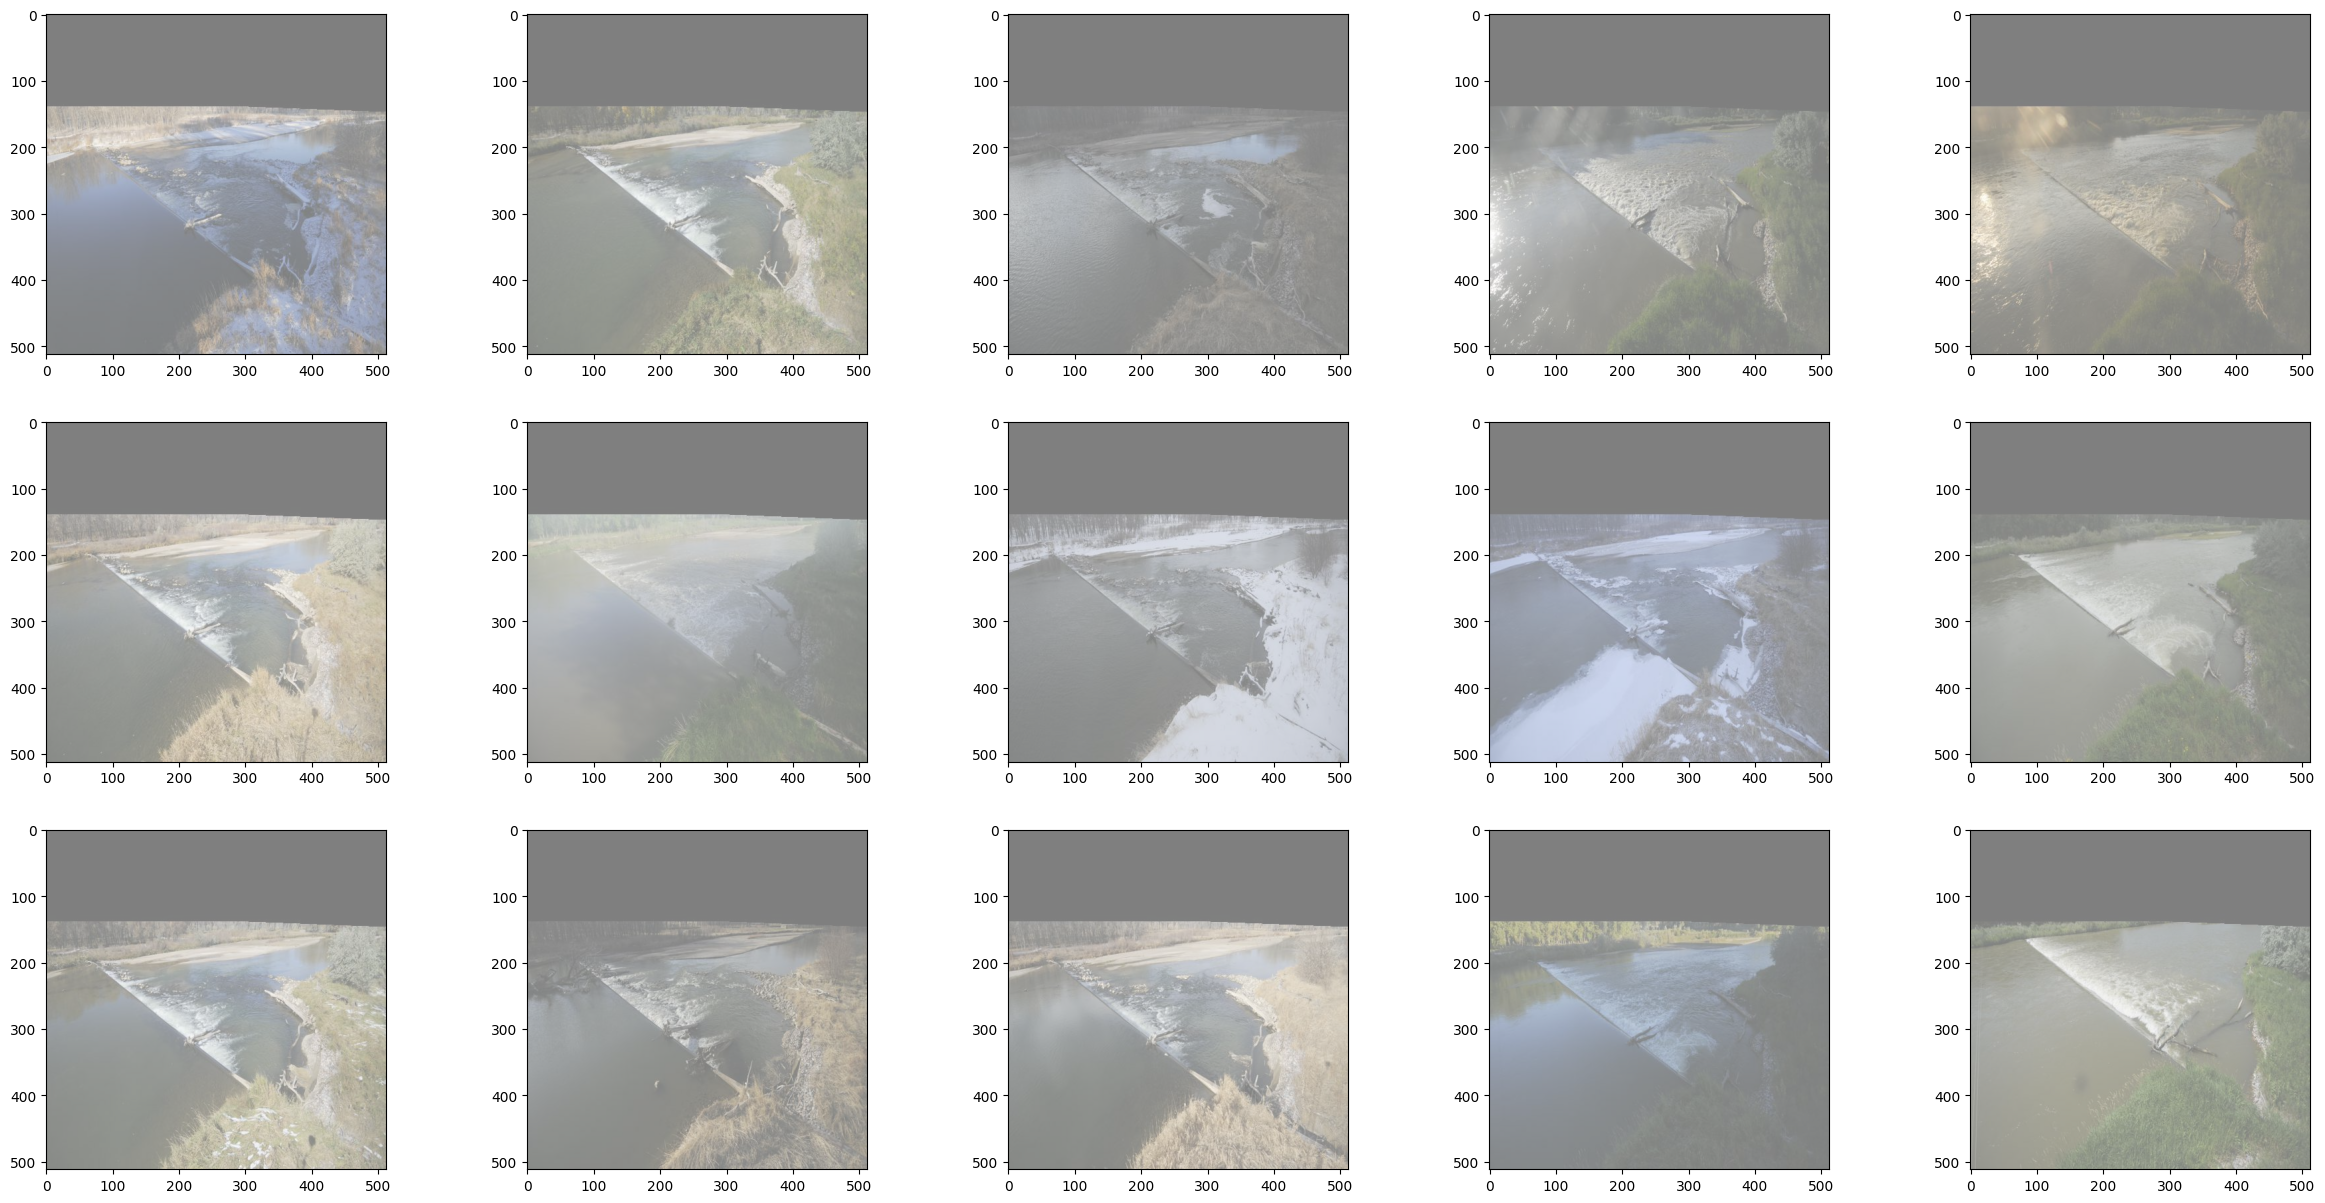

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))

for image_time, stage_discharge in test_ds.take(1):
    images = image_time[0][:15]
    #images = image_time[:15]
    for img, ax in zip(images, ax.flatten()):
        #print(img.numpy()[:,:,3])
        img = img.numpy()[:,:,:3]
        #img = img.numpy()
        img = img / 2 + 0.5     # unnormalize
        ax.imshow(img)

plt.show()

## Create model

In [21]:
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel

def sobel_kernel(shape, dtype=None):
    #print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    #print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    #print(tf.shape(sobel_x))
    return sobel_x

def gfb_filter(shape,size=3, tlist=[1,2,3], slist=[2,5], flist=[0.01,0.25], dtype=None):
    print(shape)
    fsize=np.ones([size,size])
    kernels = []
    for theta in tlist:
        theta = theta / 4. * np.pi
        for sigma in slist:
            for frequency in flist:
                kernel = np.real(gabor_kernel(frequency, theta=theta,sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    gfblist = []
    for k, kernel in enumerate(kernels):
        ck=ndi.convolve(fsize, kernel, mode='wrap')
        gfblist.append(ck)
    
    gfblist = np.asarray(gfblist).reshape(size,size,1,len(gfblist))
    gfblist = np.repeat(gfblist[:, :, :, :], gfblist.shape[1], axis=2)
    print(gfblist.shape)
    return tf.keras.backend.variable(gfblist, dtype='float32')


In [ ]:
from classification_models.keras import Classifiers

def create_model(input_shape, output_shape, option="normal"):
    model = Sequential()

    if option == "transfer":
        input_base = Input(shape=input_shape)
        base_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape)

        """base_model = ResNet34(include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape)"""
        
        for layer in base_model.layers:
            layer.trainable = False

        base_model._name = 'base_model_ResNet50V2'


        cnn_model = base_model(input_base)


        cnn_model = Dropout(0.3)(cnn_model)
        cnn_model = GlobalAveragePooling2D()(cnn_model)


        edge_detection = Conv2D(4, kernel_size=(5, 5), kernel_initializer=sobel_kernel, strides=(2, 2), activation='relu', trainable=False)

        edge_detection = edge_detection(input_base)
        edge_detection.trainable = False
        #edge_detection = tf.keras.layers.Reshape((-1, 1))(edge_detection)
        edge_detection = GlobalAveragePooling2D()(edge_detection)
        edge_detection = Dense(512, activation="elu")(edge_detection)
        edge_detection = Dense(512, activation="elu")(edge_detection)

        gfb = Conv2D(filters=12, kernel_size=3, kernel_initializer=gfb_filter, strides=1, padding='valid', trainable=False)
        gfb = gfb(input_base)
        gfb.trainable = False
        gfb = GlobalAveragePooling2D()(gfb)
        gfb = Dense(512, activation="elu")(gfb)
        gfb = Dense(512, activation="elu")(gfb)

        time_input = Input(shape=(1))

        combined = concatenate([cnn_model, edge_detection, gfb, time_input])
        combined = BatchNormalization()(combined)

        cnn_time = Dense(1024, activation="elu")(combined)
        cnn_time = Dropout(0.3)(cnn_time)
        cnn_time = Dense(1024, activation="elu")(cnn_time)
        #cnn_time = Dropout(0.3)(cnn_time)
        cnn_time = Dense(512, activation="elu")(cnn_time)
        cnn_time = Dense(512, activation="elu")(cnn_time)
        output = Dense(output_shape, activation='linear')(cnn_time)

        model = tf.keras.Model([input_base, time_input], output, name="time_cnn")
    elif option == "normal":
        model.add(Input(shape=input_shape))
        
        """model.add(Conv2D(16, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(GlobalAveragePooling2D())

        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(256, activation='elu'))
        model.add(Dense(64, activation='elu'))"""

        model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', activation="elu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation="elu", padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same'))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(32, kernel_size=(3, 3), activation='elu'))

        model.add(Conv2D(32, kernel_size=(3, 3), activation='elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='elu'))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(1024, activation='relu'))
    elif option == "cnn/lstm":
        base_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                      weights='imagenet',
                                                      input_shape=(224, 224, 3))
        base_model.trainable = False
        base_model._name = 'base_model_ResNet50'
        model.add(Input(shape=input_shape))
        model.add(TimeDistributed(base_model))
        model.add(TimeDistributed(Dropout(0.3)))
        model.add(TimeDistributed(GlobalAveragePooling2D()))

        """model.add(Input(shape=input_shape))

        model.add(TimeDistributed(Conv2D(16, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='elu')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation='elu', padding='same')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        

        model.add(TimeDistributed(Flatten()))"""

        model.add(LSTM(10, return_sequences=True))
        model.add(LSTM(15))

        model.add(Dense(512, activation='elu'))
        model.add(Dense(256, activation='elu'))
        model.add(Dense(128, activation='elu'))
        model.add(Dense(128, activation='elu'))
        
    #model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [ ]:
model = create_model(input_shape, output_shape[0], "transfer")

In [ ]:
model.summary()

Model: "time_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 510, 510, 12  336         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 254, 254, 4)  304         ['input_1[0][0]']                
                                                                                           

In [ ]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [ ]:
import tensorflow_addons as tfa

In [ ]:
sgd = SGD(learning_rate=0.01, decay=1e-3, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 200)

"""compile_model(tfa.losses.PinballLoss(tau=.6), adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])"""

compile_model(tf.keras.losses.Huber(), adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])


In [ ]:
def fit_model(training_values, validation_values=None, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [ ]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_cnn_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)


In [ ]:
# batch_size = 0 because we already have batch size in tf dataset
with tf.device("/gpu:0"):
    model_h = fit_model(train_ds, val_ds, epochs=60, steps=np.ceil(train_size / BATCH_SIZE), val_steps=np.ceil(val_size / BATCH_SIZE), callbacks=[tensorboard_callback, checkpoint_callback, es_callback])

Epoch 1/60


2022-11-07 15:17:21.450066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-07 15:17:22.673416: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-07 15:17:22.674508: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-07 15:17:22.674549: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-07 15:17:22.675691: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-07 15:17:22.675766: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-07 15:17:23.906389: W tensorflow/core/common_runtime/bf

635/635 [==============================] - ETA: 0s - loss: 0.1209 - mse: 0.7200 - rmse: 0.8485 - mae: 0.2986 - mape: 195.9039

2022-11-07 15:23:09.254915: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 755220480 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.03543, saving model to model_weights/20221107-151717_cnn_best_weights.hdf5
635/635 [==============================] - 352s 542ms/step - loss: 0.1209 - mse: 0.7200 - rmse: 0.8485 - mae: 0.2986 - mape: 195.9039 - val_loss: 0.0354 - val_mse: 0.0715 - val_rmse: 0.2674 - val_mae: 0.1851 - val_mape: 106.9622
Epoch 2/60
635/635 [==============================] - ETA: 0s - loss: 0.0140 - mse: 0.0281 - rmse: 0.1677 - mae: 0.1139 - mape: 80.8111

2022-11-07 15:28:50.997581: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 755220480 exceeds 10% of free system memory.



Epoch 2: val_loss improved from 0.03543 to 0.02830, saving model to model_weights/20221107-151717_cnn_best_weights.hdf5
635/635 [==============================] - 342s 539ms/step - loss: 0.0140 - mse: 0.0281 - rmse: 0.1677 - mae: 0.1139 - mape: 80.8111 - val_loss: 0.0283 - val_mse: 0.0572 - val_rmse: 0.2392 - val_mae: 0.1657 - val_mape: 72.7003
Epoch 3/60
635/635 [==============================] - ETA: 0s - loss: 0.0089 - mse: 0.0178 - rmse: 0.1333 - mae: 0.0917 - mape: 69.0199

2022-11-07 15:34:08.096894: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 755220480 exceeds 10% of free system memory.



Epoch 3: val_loss improved from 0.02830 to 0.02825, saving model to model_weights/20221107-151717_cnn_best_weights.hdf5
635/635 [==============================] - 317s 499ms/step - loss: 0.0089 - mse: 0.0178 - rmse: 0.1333 - mae: 0.0917 - mape: 69.0199 - val_loss: 0.0283 - val_mse: 0.0576 - val_rmse: 0.2400 - val_mae: 0.1411 - val_mape: 63.7233
Epoch 4/60
635/635 [==============================] - ETA: 0s - loss: 0.0088 - mse: 0.0177 - rmse: 0.1331 - mae: 0.0898 - mape: 61.5308

2022-11-07 15:39:11.843924: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 755220480 exceeds 10% of free system memory.



Epoch 4: val_loss improved from 0.02825 to 0.01703, saving model to model_weights/20221107-151717_cnn_best_weights.hdf5
635/635 [==============================] - 304s 478ms/step - loss: 0.0088 - mse: 0.0177 - rmse: 0.1331 - mae: 0.0898 - mape: 61.5308 - val_loss: 0.0170 - val_mse: 0.0344 - val_rmse: 0.1854 - val_mae: 0.1276 - val_mape: 53.6718
Epoch 5/60
635/635 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0147 - rmse: 0.1212 - mae: 0.0821 - mape: 59.8551

2022-11-07 15:44:15.509865: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 755220480 exceeds 10% of free system memory.



Epoch 5: val_loss did not improve from 0.01703
635/635 [==============================] - 303s 477ms/step - loss: 0.0073 - mse: 0.0147 - rmse: 0.1212 - mae: 0.0821 - mape: 59.8551 - val_loss: 0.0269 - val_mse: 0.0557 - val_rmse: 0.2361 - val_mae: 0.1483 - val_mape: 91.4981
Epoch 6/60
635/635 [==============================] - ETA: 0s - loss: 0.0056 - mse: 0.0113 - rmse: 0.1061 - mae: 0.0718 - mape: 53.5785
Epoch 6: val_loss did not improve from 0.01703
635/635 [==============================] - 303s 477ms/step - loss: 0.0056 - mse: 0.0113 - rmse: 0.1061 - mae: 0.0718 - mape: 53.5785 - val_loss: 0.0284 - val_mse: 0.0580 - val_rmse: 0.2407 - val_mae: 0.1704 - val_mape: 87.5498
Epoch 7/60
635/635 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0136 - rmse: 0.1166 - mae: 0.0744 - mape: 52.8746
Epoch 7: val_loss did not improve from 0.01703
635/635 [==============================] - 303s 478ms/step - loss: 0.0066 - mse: 0.0136 - rmse: 0.1166 - mae: 0.0744 - mape: 52.8746

## Evaluate model

In [ ]:
print(date_actual)

20221107-151717


In [ ]:
best_model = models.load_model(f'model_weights/{date_actual}_cnn_best_weights.hdf5', custom_objects={"gfb_filter": gfb_filter, "sobel_kernel": sobel_kernel})
#best_model = models.load_model(f'model_weights/{date_actual}_cnn_best_weights.hdf5', custom_objects={"gfb_filter": gfb_filter, "sobel_kernel": sobel_kernel})
#best_model = models.load_model(f'best_models_weights/cnn_best_weights_v9.hdf5')


(3, 3, 3, 12)
(3, 3, 3, 12)


In [ ]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [ ]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds, steps=np.ceil(test_size / BATCH_SIZE))

398/398 [==============================] - 141s 352ms/step - loss: 0.0151 - mse: 0.0304 - rmse: 0.1744 - mae: 0.1107 - mape: 84.0974


In [ ]:
#predictions = best_model.predict(test_ds, steps=np.ceil(test_size / BATCH_SIZE))

In [ ]:
for image, stage_discharge in test_ds.take(1):
	predictions = best_model.predict(x=image)

	stage_discharge_test_values = stage_discharge.numpy()
	predictions_values = predictions
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	#stage_discharge_test_values = stage_discharge_test_values.numpy().reshape(10, 2)
	stage_discharge_test_values = stage_discharge_test_values.numpy()
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values)):
		#print(f"pred stage: {scaler.inverse_transform(predictions_values)[i][0]}, actual stage: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")
		#print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][1]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][1]}")
		print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][0]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")

1/1 [==============================] - 1s 577ms/step
133.7847744697119
409.95659994963336
pred discharge: 119.1798324584961, actual discharge: 194.0000000000001
pred discharge: 1347.485595703125, actual discharge: 1300.0
pred discharge: 303.8089294433594, actual discharge: 488.0
pred discharge: 640.7224731445312, actual discharge: 548.0
pred discharge: 184.8164825439453, actual discharge: 72.70000000000005
pred discharge: 740.2110595703125, actual discharge: 1100.0
pred discharge: 1776.2406005859375, actual discharge: 1280.0
pred discharge: 1391.607421875, actual discharge: 1320.0
pred discharge: 1352.530517578125, actual discharge: 1370.0
pred discharge: 1404.2039794921875, actual discharge: 1190.0


### Residual analysis

In [ ]:
y_predictions = np.empty(shape=(1, 1)).astype('float32')
y_real = np.empty(shape=(1, 1)).astype('float32')
images_worst_values = []

for image, stage_discharge in test_ds.take(200):
    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))
    y_real = np.concatenate((y_real, stage_discharge.numpy()))
    #images_worst_values.append(image.numpy())

1/1 [==============================] - 0s 59ms/step


#### Check what values are the worst performers

In [ ]:
#images_worst_values = np.array(images_worst_values)
#images_worst_values.shape

In [ ]:
#images_worst_values = images_worst_values.reshape(4800, 224, 224, 3)

In [ ]:
residuals_for_images = np.abs(y_real - y_predictions).flatten()
y_predictions_for_images = scaler.inverse_transform(y_predictions)
y_real_for_images = scaler.inverse_transform(y_real)

indexes_for_images_worst_pred = np.argpartition(residuals_for_images, -100)[-100:]

print(list(zip(y_real_for_images[indexes_for_images_worst_pred].flatten(), y_predictions_for_images[indexes_for_images_worst_pred].flatten())))

[(2010.0, 1151.211), (2770.0, 3629.105), (2740.0, 1880.058), (2440.0, 1565.5618), (2960.0, 3833.8196), (2080.0, 2942.4), (2770.0, 1892.9034), (2160.0, 3024.4187), (3100.0, 3962.0642), (2410.0, 1546.6788), (2400.0, 1524.7319), (2960.0, 3820.3848), (2110.0, 2986.814), (2740.0, 1862.542), (2680.0, 3574.0796), (3100.0, 3996.9072), (2750.0, 3686.5254), (3100.0, 4032.143), (2740.0, 1802.5076), (2740.0, 1818.3813), (2010.0, 2992.3728), (2660.0, 3549.6074), (2850.0, 1875.6128), (2380.0, 3364.6567), (1930.0, 2840.8647), (2170.0, 3075.3064), (2760.0, 1879.0608), (2900.0, 3885.5127), (268.0, 1197.8815), (2380.0, 3339.2263), (3120.0, 4064.651), (2660.0, 3604.3284), (1880.0, 2792.6597), (2750.0, 3657.402), (2720.0, 1760.5782), (2770.0, 1845.5238), (2760.0, 1790.7268), (1140.0, 2027.4209), (2910.0, 3821.2485), (2170.0, 3091.5366), (2750.0, 1755.749), (2160.0, 3154.3125), (2720.0, 1601.7493), (2370.0, 3451.8342), (2420.0, 3668.493), (2280.0, 3415.5972), (990.0, 2515.7637), (3080.0, 4254.152), (2160.0

In [ ]:
"""fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(30, 20))

print_images_worst_values = images_worst_values[indexes_for_images_worst_pred]

for img, ax in zip(print_images_worst_values[:30], ax.flatten()):
    img = img / 2 + 0.5     # unnormalize
    ax.imshow(img)

plt.show()"""

'fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(30, 20))\n\nprint_images_worst_values = images_worst_values[indexes_for_images_worst_pred]\n\nfor img, ax in zip(print_images_worst_values[:30], ax.flatten()):\n    img = img / 2 + 0.5     # unnormalize\n    ax.imshow(img)\n\nplt.show()'

#### Check residuals

0.1702690167857211


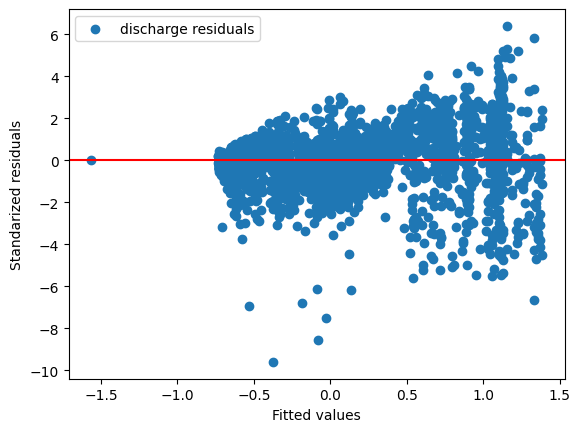

In [ ]:
residuals = y_real - y_predictions
residuals_std = residuals/residuals.std()

#y_real_stage = np.array([i[0] for i in y_real])
#residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[0] for i in y_real])
residual_discharge = np.array([i[0] for i in residuals])

print(residual_discharge.std())

#plt.scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel("Fitted values")
plt.ylabel("Standarized residuals")

plt.legend()
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

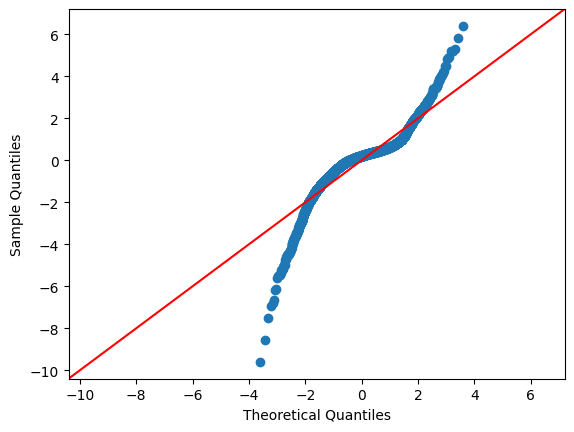

In [ ]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

In [ ]:
"""plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()"""

"plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)\nplt.ylabel('Count')\nplt.xlabel('Residual stage');\nplt.show()"

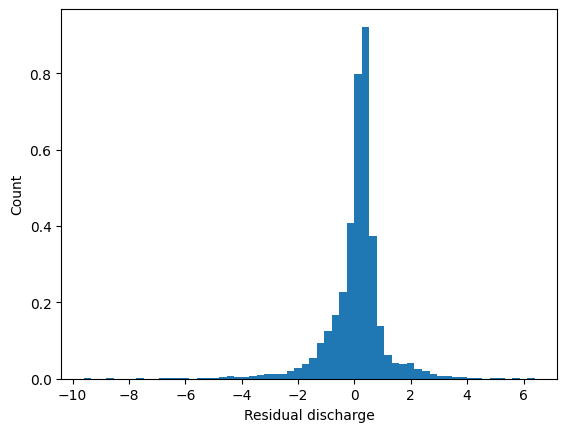

In [ ]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [ ]:
"""stat, pval = normal_ad(residual_stage)
print("p-value:", pval)

if pval<0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")"""

'stat, pval = normal_ad(residual_stage)\nprint("p-value:", pval)\n\nif pval<0.05:\n    print("Hay evidencia de que los residuos no provienen de una distribución normal.")\nelse:\n    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")'

In [ ]:
stat, pval = normal_ad(residual_discharge / residual_discharge.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


## Visualize layers

In [ ]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [ ]:
activations = activation_model.predict(test_ds.take(1)) 

1/1 [==============================] - 0s 369ms/step


conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
conv2d_3
conv2d_4
max_pooling2d_2
conv2d_5
conv2d_6
max_pooling2d_3


MemoryError: Unable to allocate 91.1 GiB for an array with shape (331776, 36864) and data type float64

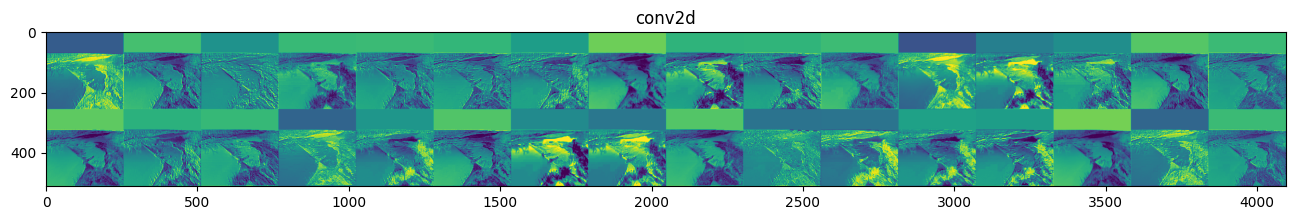

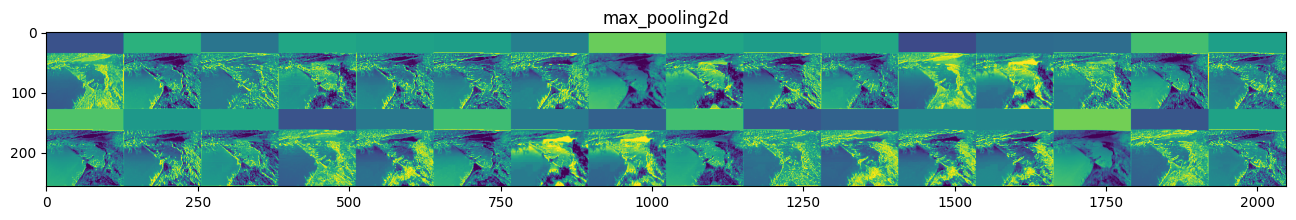

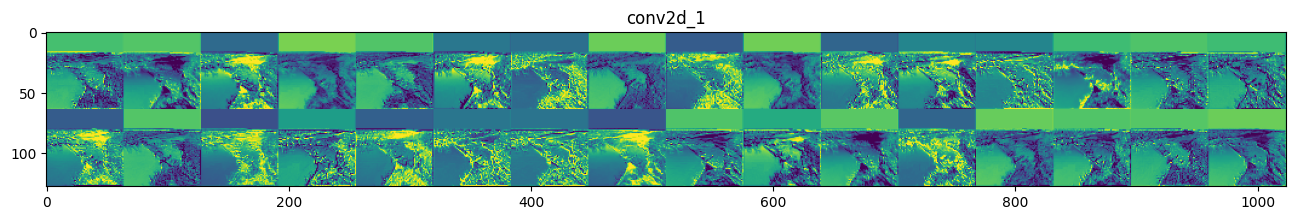

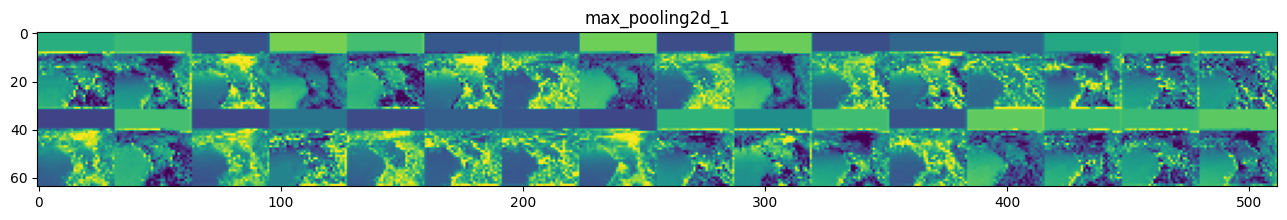

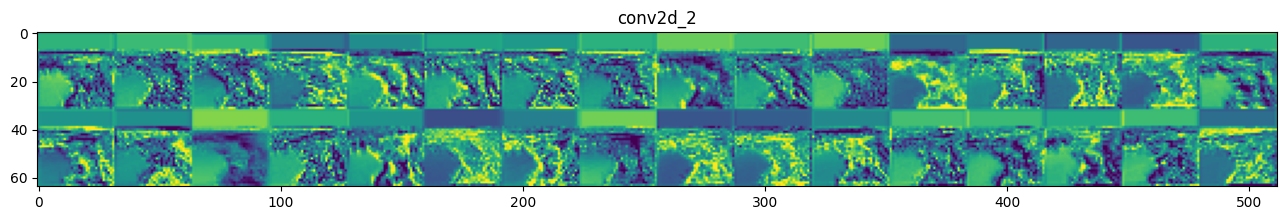

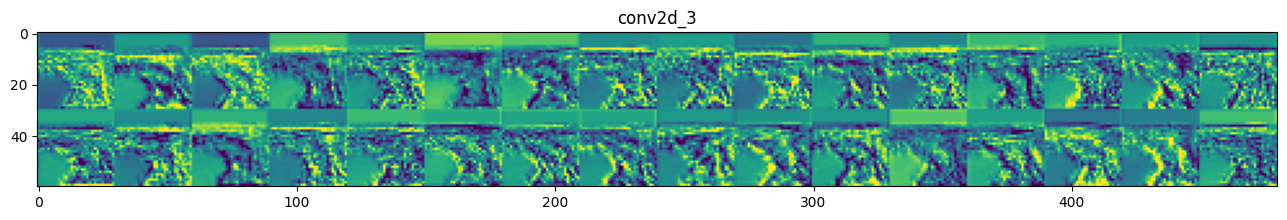

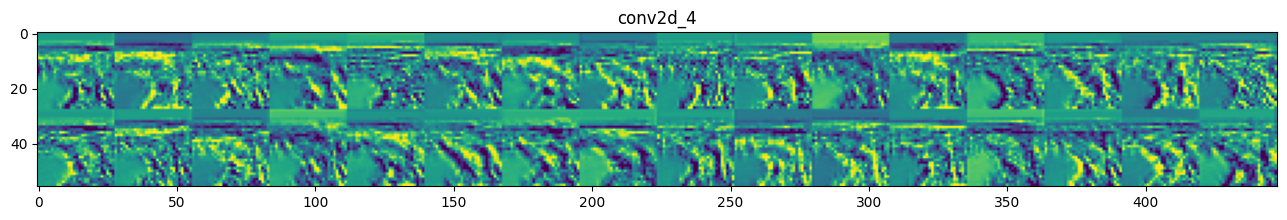

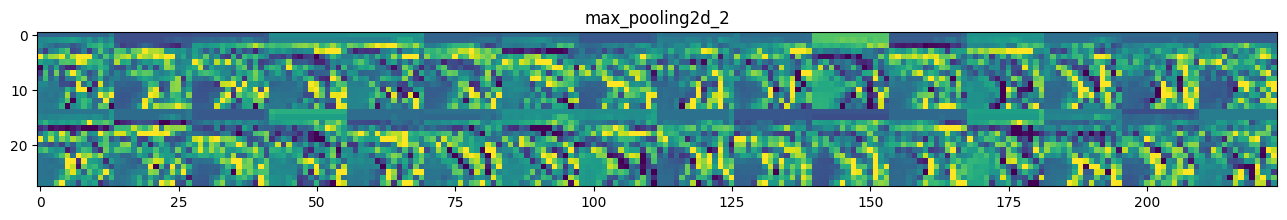

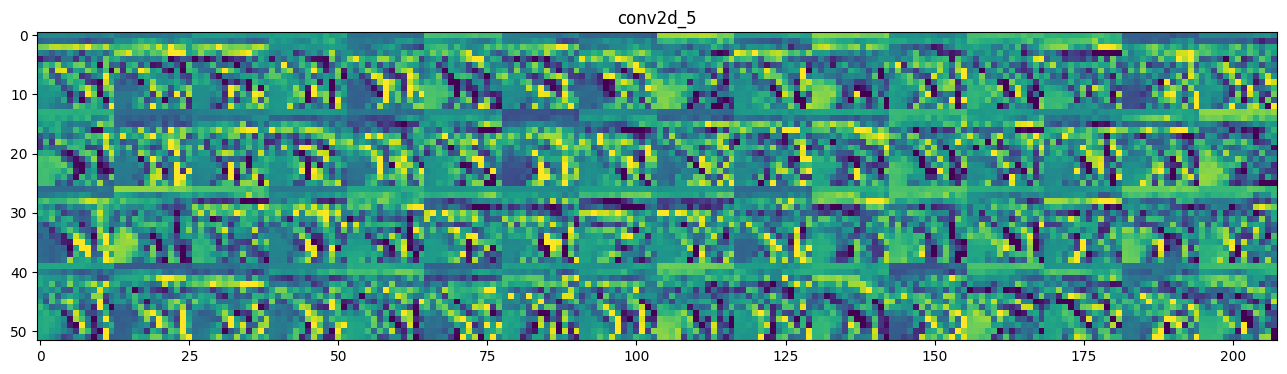

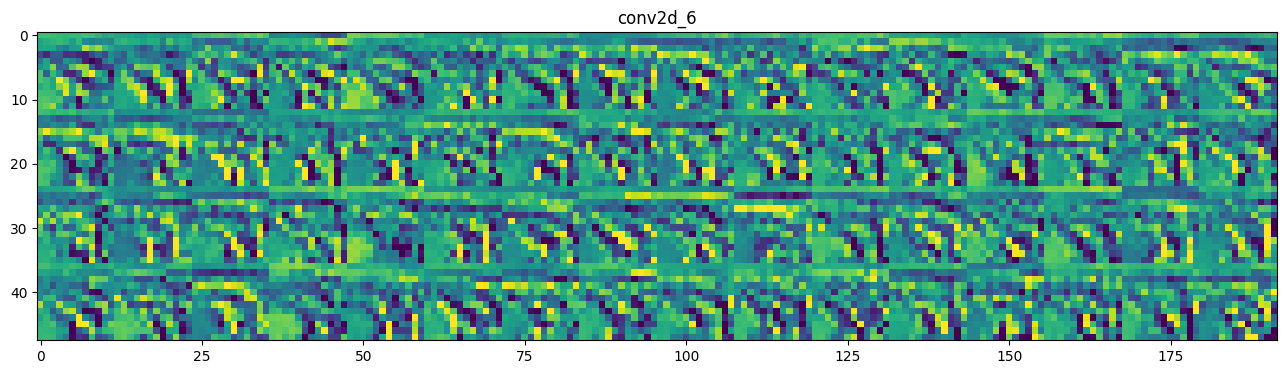

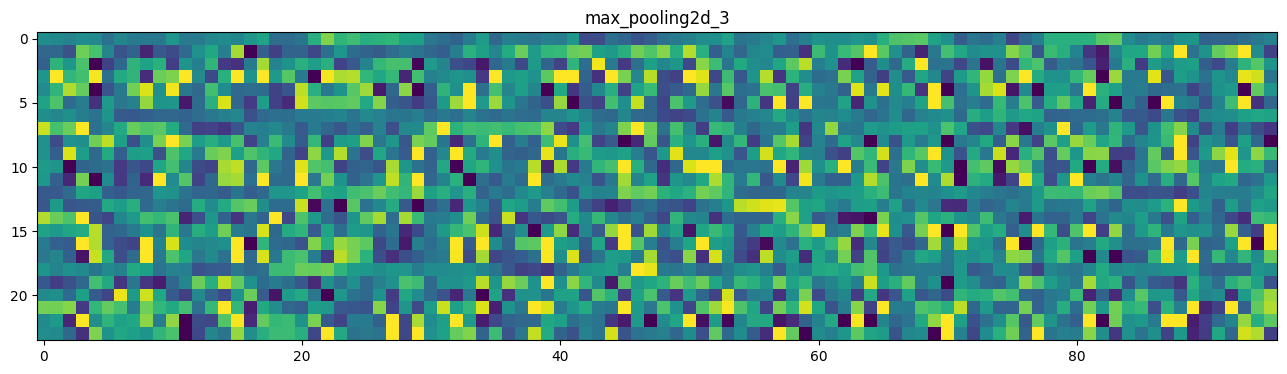

In [ ]:
import matplotlib.pyplot as plt

layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if "flatten" in layer_name or "dense" in layer_name: break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')